In [333]:
import Convex
using LinearAlgebra, Plots
include("z3_utility.jl")
include("smc.jl")

solve! (generic function with 5 methods)

In [334]:
# In this problem we want to plan a 2D trajectory x,y over N steps
# TODO we may complicate it later by adding a quadratic approximation to nonlinear dynamics

N = 10
x = Variable(N, :Real)
y = Variable(N, :Real)

Variable
size: (10, 1)
sign: real
vexity: affine
id: 260…973

In [335]:
x_world = [0.,10.]
y_world = [0.,5.]
bounds = [0.,0.,10.,5.]
start   = [0.25,0.25]
goal    = [9.75, 2.]

# obstacles are represented by two corners (x1, y1, x2, y2)
obs_1 = [2.,0.,4.,3.]
obs_2 = [7.,1.,9.,3.5]
obs_3 = [7.,4.,9.,5.]

plot_rect(obs) = (obs[[1,3,3,1,1]], obs[[2,2,4,4,2]])

function plot_env()
    plot(plot_rect(bounds)..., color=:green, xlim=x_world, ylim=y_world, primary=false)
    plot!(plot_rect(obs_1)..., color=:red, primary=false)
    plot!(plot_rect(obs_2)..., color=:red, primary=false)
    plot!(plot_rect(obs_3)..., color=:red, primary=false)
    scatter!(start[1:1], start[2:2], markersize=5, color=:blue)
    scatter!(goal[1:1], goal[2:2], markersize=5, color=:orange, marker=:star)
end

plot_env (generic function with 1 method)

In [336]:
function outside_box_at_step(xi, yi, box::Array{Float64}) :: Array{NodeType}
    x1, y1, x2, y2 = box
    return [(xi <= x1) ∨ (xi >= x2), (yi <= y1) ∨ (yi >= y2)]
end
function outside_box_in_interval(x, y, box, N1=1, N2=Inf)
    if length(x) != length(y)
        println("Warning: x and y are different lengths")
    end
    if isinf(N2)
        N2 = min(length(x), length(y))
    end
    return reduce(vcat, map( (i) -> outside_box_at_step(x[i], y[i], box), N1:N2 ))
end

outside_box_in_interval (generic function with 3 methods)

In [342]:
umax = 10.0
control_bounds = map( (i) -> Convex.square(x[i]) + Convex.square(y[i]) <= umax, 1:N )

constraints = vcat([(x >= bounds[1])∧ (y >= bounds[2])∧(x <= bounds[3])∧ (y <= bounds[4])],
    [(x[1] == start[1])∧ (y[1] == start[2])∧ (x[end] == goal[1])∧ (y[end] == goal[2])],
                 #  control_bounds,
                   outside_box_in_interval(x, y, obs_1),
                  # outside_box_in_interval(x, y, obs_2),
                 #  outside_box_in_interval(x, y, obs_3),
                  )

problem = SmcProblem(constraints)
solve!(problem)

optval -1.1375160235296408e-7


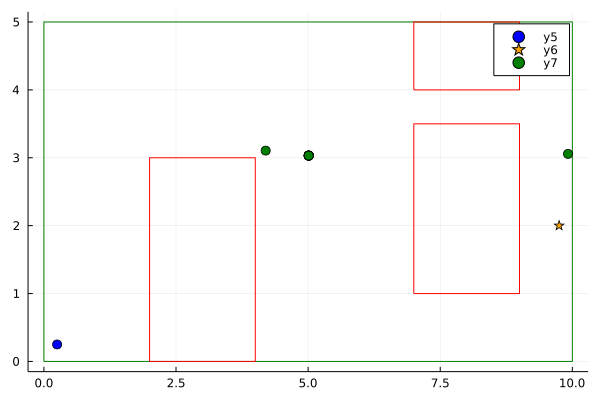

In [338]:
plot_env()
scatter!(x.value, y.value, color=:green, markersize=5)

In [339]:
x.value

10×1 Matrix{Float64}:
 4.196725542105072
 5.011145856465111
 5.011145856465111
 5.011145856465111
 5.011145856465111
 5.011145856465111
 5.011145856465111
 5.011145856465111
 5.011145856465112
 9.918463146661319

In [340]:
y.value

10×1 Matrix{Float64}:
 3.105247294156767
 3.0323300156563504
 3.0323300156563504
 3.0323300156563504
 3.0323300156563504
 3.0323300156563504
 3.0323300156563504
 3.0323300156563504
 3.0323300156563504
 3.0568708320682108